In [2]:
import os, sys, random
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

import dcor

# import xgboost as xgb

# scikit-learn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

In [5]:
BASEDIRECTORY = "/Users/phillip/Documents/PhD/PhD3/Data/PhysioNet/dataset/"

In [6]:
temp = pd.read_csv("{}/p000050.psv".format(BASEDIRECTORY), sep="|")

In [9]:
temp.head(10).to_csv('{}/test.csv'.format("/Users/phillip/Documents/PhD/PhD3/Data/PhysioNet/"))

In [4]:
def isClean(data: "ndarray") -> bool:
    """
    check whether the input dataframe is clean
    
    :param data: a 2-d ndarray retrieved by calling df.values
    :return: bool value indicating whether the input dataframe is clean
    """
    if (
        "***" in data
        or "+++" in data
        or "APN" in data
        or "ASY" in data
        or " VF" in data
        or "   " in data
        or "LRN" in data
        or "---" in data
    ):
        return False
    else:
        return True


def whatIsTheNoise(data: "ndarray") -> str:
    """
    check what is the noise among the input data
    
    :param data: a 2-d ndarray retrieved by calling df.values
    :return: str containing the outlier characters
    """
    retStr = ""

    if "***" in data:
        retStr += "***, "
    if "+++" in data:
        retStr += "+++, "
    if "APN" in data:
        retStr += "APN, "
    if "ASY" in data:
        retStr += "ASY, "
    if " VF" in data:
        retStr += " VF, "
    if "   " in data:
        retStr += "   , "
    if "LRN" in data:
        retStr += "LRN, "
    if "---" in data:
        retStr += "---, "

    if retStr == "":
        retStr = "All Clear!"

    return retStr


def calcMissingLine(df: "DataFrame") -> int:
    """
    calculate # of lines with missing values.
    
    :param df: the DataFrame to be analysed
    :return: # lines with missing values
    """

    count = (df.isna().sum(axis=1) > 0).sum()

    return count


def calcMissingValue(df: "DataFrame") -> int:
    """
    calculate the missing ratio by value
    
    :param df: the DataFrame to be analysed
    :return: # missing values / # total values
    """
    df.replace("***", np.nan, inplace=True)
    df.replace("+++", np.nan, inplace=True)
    df.replace("APN", np.nan, inplace=True)
    df.replace("ASY", np.nan, inplace=True)
    df.replace(" VF", np.nan, inplace=True)
    df.replace("   ", np.nan, inplace=True)
    df.replace("LRN", np.nan, inplace=True)
    df.replace("---", np.nan, inplace=True)

    #     df = df.astype("float64")

    nMissing = df.isna().sum().sum()

    return nMissing

In [5]:
# how many hours of data in total

nLines = 0
nLinesWithMissing = 0
nMissing = 0
nTotalValue = 0

dfList = []

fileNameList = os.listdir(BASEDIRECTORY)
for file in fileNameList:
    temp = pd.read_csv("{}/{}".format(BASEDIRECTORY, file), sep="|")
    dfList.append(temp)

mergedDF = pd.concat(dfList)
# mergedDF = mergedDF[['ART D', 'ART M', 'ART S', 'HR', 'SpO2', 'RESP', 'PLS', '25255']]

print(len(mergedDF))
# print(calcMissingLine(mergedDF))
# print(calcMissingValue(mergedDF))
# print(mergedDF.shape[0] * mergedDF.shape[1])

1552162


In [6]:
mergedDF.index = np.arange(len(mergedDF))
mergedDF = mergedDF.astype("float64")

In [15]:
# descriptive statistics

stat_df = pd.DataFrame(
    {
        "mean": mergedDF.mean(),
        "max": mergedDF.max(),
        "min": mergedDF.min(),
        "median": mergedDF.median(),
        "std": mergedDF.std(),
    }
)
stat_df.index = mergedDF.columns
stat_df = stat_df.round(decimals=2)

# print(mergedDF.mean())
# print('********************')
# print(mergedDF.max())
# print('********************')
# print(mergedDF.min())
# print('********************')
# print(mergedDF.median())
# print('********************')
# print(mergedDF.std())

In [16]:
stat_df.to_csv("stat_df.csv")

In [11]:
stat_df.head()

,mean,max,min,median,std
HR,84.581603,280.0,20.0,83.5,17.325457
O2Sat,97.194012,100.0,20.0,98.0,2.936940
Temp,36.977209,50.0,20.9,37.0,0.770012
SBP,123.749913,300.0,20.0,121.0,23.231699
MAP,82.400145,300.0,20.0,80.0,16.341958


In [14]:
stat_df.round(decimals=2)

,mean,max,min,median,std
HR,84.58,280.00,20.00,83.50,17.33
O2Sat,97.19,100.00,20.00,98.00,2.94
Temp,36.98,50.00,20.90,37.00,0.77
SBP,123.75,300.00,20.00,121.00,23.23
MAP,82.40,300.00,20.00,80.00,16.34
DBP,63.83,300.00,20.00,62.00,13.96
Resp,18.73,100.00,1.00,18.00,5.10
EtCO2,32.96,100.00,10.00,33.00,7.95
BaseExcess,-0.69,100.00,-32.00,0.00,4.29
HCO3,24.08,55.00,0.00,24.00,4.38


In [42]:
mergedDF.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,59.0,1.0,1.0,0.0,-6.01,1.0,0.0
1,102.0,100.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59.0,1.0,1.0,0.0,-6.01,2.0,0.0
2,102.0,100.0,NaN,99.0,84.0,76.0,18.5,NaN,NaN,NaN,...,NaN,NaN,NaN,59.0,1.0,1.0,0.0,-6.01,3.0,0.0
3,124.0,100.0,NaN,97.0,70.0,55.0,16.0,NaN,NaN,NaN,...,NaN,NaN,NaN,59.0,1.0,1.0,0.0,-6.01,4.0,0.0
4,98.0,100.0,NaN,95.0,73.0,62.0,18.0,NaN,NaN,NaN,...,6.8,NaN,276.0,59.0,1.0,1.0,0.0,-6.01,5.0,0.0


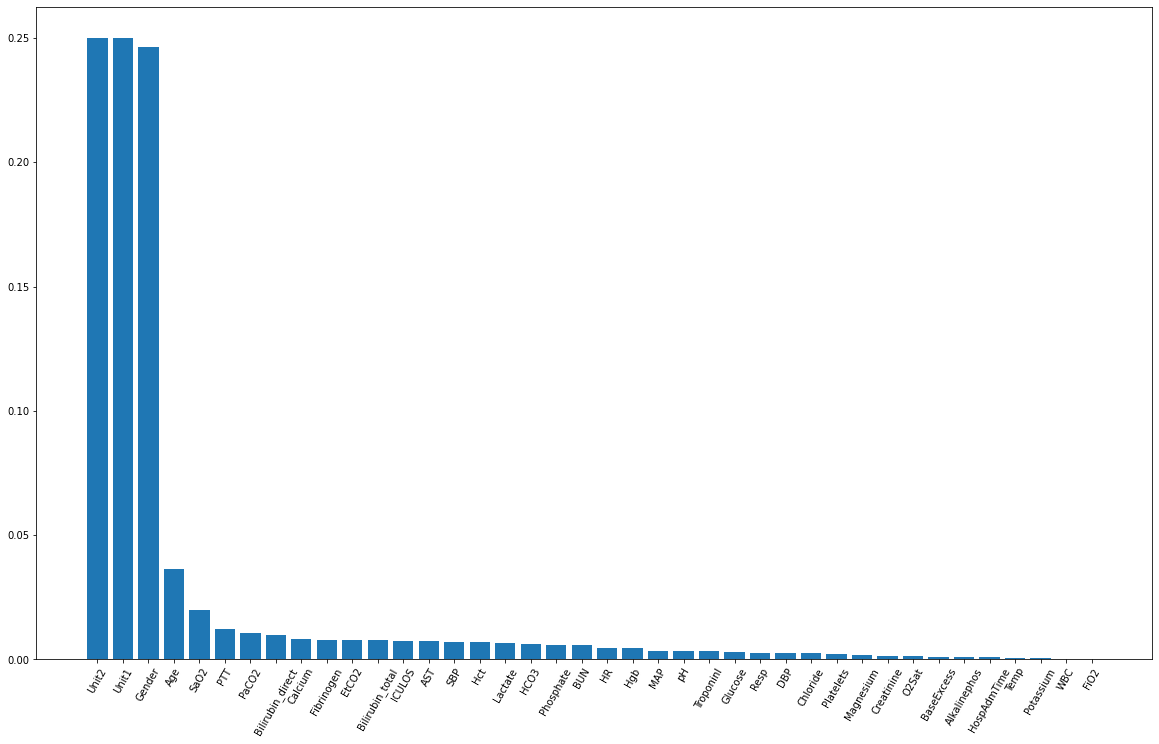

In [29]:
# scale first
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(mergedDF), columns=mergedDF.columns)

# variance threshold
v = scaled_df.var()
plt.figure(figsize=(20, 12))
plt.bar(v[:-1].sort_values(ascending=False).index, v[:-1].sort_values(ascending=False))
plt.xticks(rotation=60)
plt.savefig("variance_physionet_data.png")
plt.show()

In [20]:
v.round(decimals=4).to_csv("variance_physionet.csv")

In [10]:
# fillna with 0s
nafilled_df = mergedDF.fillna(0)

In [32]:
# pearson correlation coefficeint
kept_features = ["Age", "ICULOS", "HR", "Resp", "SaO2", "SBP", "DBP"]
ppc_matrix = pd.DataFrame(
    np.zeros([len(kept_features), len(kept_features)]),
    index=kept_features,
    columns=kept_features,
)
pvalue_matrix = pd.DataFrame(
    np.zeros([len(kept_features), len(kept_features)]),
    index=kept_features,
    columns=kept_features,
)
for i in range(len(kept_features)):
    for j in range(len(kept_features)):
        pair = mergedDF[[kept_features[i], kept_features[j]]].dropna()
        #         print(pair[kept_features[i]])
        ppc = pearsonr(pair.iloc[:, 0].values, pair.iloc[:, 1].values)
        ppc_matrix.iloc[i][j] = ppc[0]
        pvalue_matrix.iloc[i][j] = ppc[1]

In [33]:
ppc_matrix

,Age,ICULOS,HR,Resp,SaO2,SBP,DBP
Age,1.000000,0.010451,-0.157267,0.032646,-0.094949,0.024549,-0.265575
ICULOS,0.010451,1.000000,0.045367,0.097995,-0.002810,0.056303,0.012472
HR,-0.157267,0.045367,1.000000,0.226016,-0.010731,-0.033704,0.129354
Resp,0.032646,0.097995,0.226016,1.000000,-0.023562,0.045857,0.061926
SaO2,-0.094949,-0.002810,-0.010731,-0.023562,1.000000,0.106002,0.064662
SBP,0.024549,0.056303,-0.033704,0.045857,0.106002,1.000000,0.539766
DBP,-0.265575,0.012472,0.129354,0.061926,0.064662,0.539766,1.000000


In [34]:
pvalue_matrix

,Age,ICULOS,HR,Resp,SaO2,SBP,DBP
Age,0.000000e+00,9.362387e-39,0.000000,1.290948e-306,1.717546e-107,7.717741e-176,0.000000e+00
ICULOS,9.362387e-39,0.000000e+00,0.000000,0.000000e+00,5.155493e-01,0.000000e+00,6.244154e-38
HR,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.559575e-02,0.000000e+00,0.000000e+00
Resp,1.290948e-306,0.000000e+00,0.000000,0.000000e+00,2.355695e-07,0.000000e+00,0.000000e+00
SaO2,1.717546e-107,5.155493e-01,0.015596,2.355695e-07,0.000000e+00,1.488647e-125,4.392510e-46
SBP,7.717741e-176,0.000000e+00,0.000000,0.000000e+00,1.488647e-125,0.000000e+00,0.000000e+00
DBP,0.000000e+00,6.244154e-38,0.000000,0.000000e+00,4.392510e-46,0.000000e+00,0.000000e+00


In [37]:
ppc_matrix.round(decimals=4).to_csv("ppc_matrix_physionet.csv")
pvalue_matrix.round(decimals=4).to_csv("pvalue_matrix_physionet.csv")

In [39]:
# Distance correlation coefficient
dcc_matrix = pd.DataFrame(
    np.zeros([len(kept_features), len(kept_features)]),
    index=kept_features,
    columns=kept_features,
)
for i in range(len(kept_features)):
    for j in range(len(kept_features)):
        pair = mergedDF[[kept_features[i], kept_features[j]]].dropna()
        #         print(pair[kept_features[i]])
        dcc = dcor.distance_correlation(pair.iloc[:, 0].values, pair.iloc[:, 1].values)
        dcc_matrix.iloc[i][j] = dcc

In [40]:
dcc_matrix

,Age,ICULOS,HR,Resp,SaO2,SBP,DBP
Age,1.000000,0.024344,0.147183,0.045226,0.095689,0.032175,0.270555
ICULOS,0.024344,1.000000,0.045457,0.097350,0.065496,0.062861,0.025557
HR,0.147183,0.045457,1.000000,0.209597,0.027376,0.034310,0.120905
Resp,0.045226,0.097350,0.209597,1.000000,0.066472,0.049324,0.062828
SaO2,0.095689,0.065496,0.027376,0.066472,1.000000,0.100028,0.064990
SBP,0.032175,0.062861,0.034310,0.049324,0.100028,1.000000,0.508214
DBP,0.270555,0.025557,0.120905,0.062828,0.064990,0.508214,1.000000


In [41]:
dcc_matrix.round(decimals=4).to_csv("dcc_physionet.csv")

In [54]:
# tree-based feature selection

df_normal = mergedDF[mergedDF.SepsisLabel == 0]
df_sepsis = mergedDF[mergedDF.SepsisLabel == 1]

sample_index = random.sample(range(len(df_normal)), len(df_sepsis))
df_normal = df_normal.iloc[sample_index, :]


# Create test set
X_train, X_test, y_train, y_test = train_test_split(
    pd.concat(
        [df_normal.drop(columns="SepsisLabel"), df_sepsis.drop(columns="SepsisLabel")],
        axis=0,
    ),
    pd.concat([df_normal["SepsisLabel"], df_sepsis["SepsisLabel"]], axis=0,),
    test_size=0.2,
)

# Create training set and validation set
# the ratio is training:validation:test = 6:2:2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [62]:
X_train

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
1505587,71.0,97.0,37.78,129.5,71.67,93.0,32.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,52.51,0.0,NaN,NaN,-0.01,205.0
437152,66.0,97.0,NaN,147.0,114.33,NaN,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,44.68,0.0,NaN,NaN,-1.17,6.0
144413,75.0,98.5,NaN,131.0,105.00,89.0,18.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,51.00,1.0,1.0,0.0,-19.19,3.0
1002913,81.5,99.0,36.80,118.5,83.50,64.0,12.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,81.82,0.0,0.0,1.0,-2.91,11.0
1042031,52.0,94.0,36.06,NaN,69.00,NaN,17.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,64.65,1.0,NaN,NaN,-0.02,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019636,89.0,99.0,NaN,NaN,83.00,NaN,28.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,66.22,1.0,NaN,NaN,-0.02,54.0
1537953,125.0,96.0,NaN,109.0,71.67,NaN,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,59.33,1.0,0.0,1.0,-24.91,29.0
721796,82.0,97.0,37.20,125.0,81.00,63.0,23.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,47.00,1.0,0.0,1.0,0.00,81.0
1303693,83.0,100.0,NaN,169.0,105.00,72.0,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,73.27,1.0,NaN,NaN,-0.03,51.0


In [56]:
# convert to DMatrix format used in xgboost
dtrain = xgb.DMatrix(X_train, label=y_train, silent=True)
dtest = xgb.DMatrix(X_test, label=y_test, silent=True)

# set initial training parameters
num_round = 500
cv_folds = 5
early_stopping_rounds = 50

# the switch to control whether we do cross validation to determine the best value of parameter "n_estimators"
# if you set it to True please change the value of "num_round" above to a lager number e.g. 10000
isCV = False

# if your computer does not support CUDA, please remove the parameter "tree_method" and "gpu_id"
clf = xgb.XGBClassifier(
    n_estimators=num_round,
    learning_rate=0.3,
    subsample=0.8,
    early_stopping_rounds=early_stopping_rounds,
    #     tree_method="gpu_hist",
    gamma=0.2,
    #     gpu_id=0,
    seed=0,
    nthread=4,
    silent=False,
)

if isCV:
    params = clf.get_params()
    cv_result = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=clf.get_params()["n_estimators"],
        nfold=cv_folds,
        metrics="auc",
        early_stopping_rounds=50,
        verbose_eval=100,
    )
    clf.set_params(n_estimators=cv_result.shape[0])

clf.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=["auc", "error"],
    verbose=False,
)

# prediction with training set
train_preds_prob = clf.predict(X_train)
train_preds = [round(value) for value in train_preds_prob]
print("Accuracy (train): %.4g" % metrics.accuracy_score(y_train, train_preds))
print("AUC (train): %f" % metrics.roc_auc_score(y_train, train_preds_prob))

# prediction with test set
test_preds_prob = clf.predict(X_test)
test_preds = [round(value) for value in test_preds_prob]
print("Accuracy (test): %.4g" % metrics.accuracy_score(y_test, test_preds))
print("AUC (test): %f" % metrics.roc_auc_score(y_test, test_preds_prob))

/Users/yifeihu/opt/anaconda3/envs/dev/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { early_stopping_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 0.9842
AUC (train): 0.984217
Accuracy (test): 0.8231
AUC (test): 0.823007


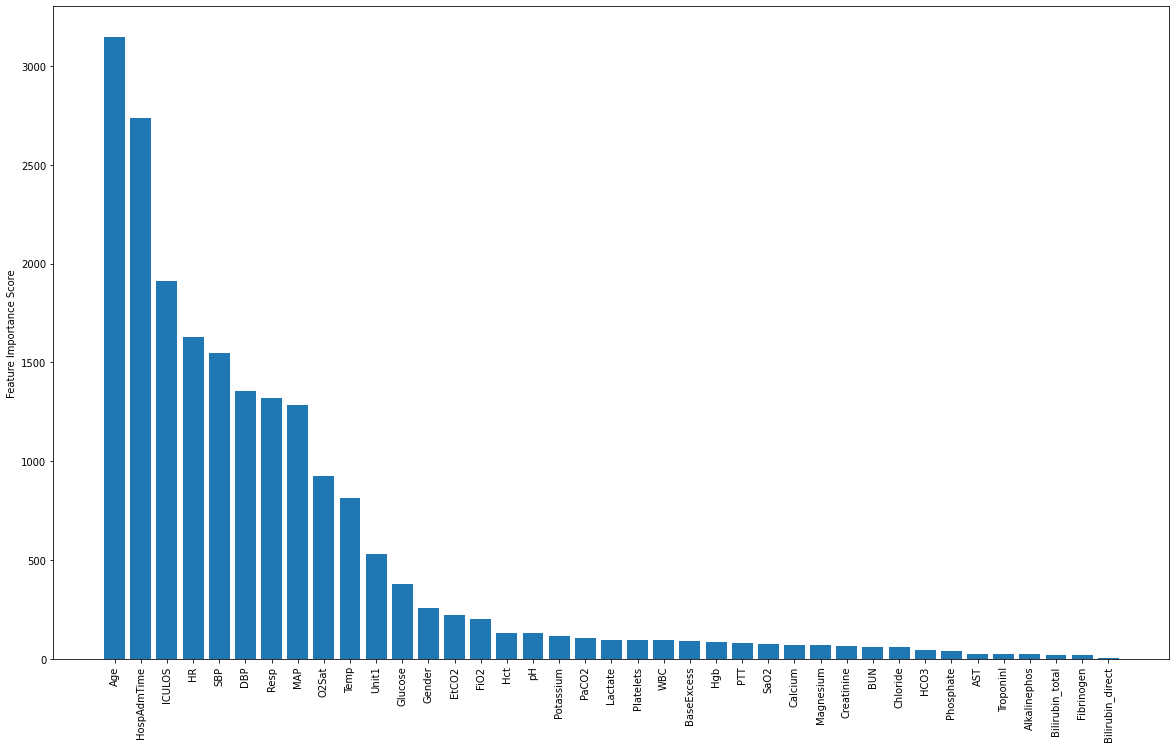

In [63]:
# print out feature importance
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(20, 12))
plt.bar(feat_imp.index, feat_imp)
plt.xticks(rotation=90)
plt.ylabel("Feature Importance Score")
plt.savefig("feature_importance_xgboost_physionet.png")